# Unstructured Data Analytics Assignment #1
Malik Ouda, Noah Placke, Mounika Tarigopula, Sarah Teng, Timothy Wong \
Unstructured Data Analytics - Anitesh Barua \
Fall 2020



Forum Link: https://forums.edmunds.com/discussion/8/general/x/car-commercials-the-good-the-bad-and-the-annoying

In [ ]:
# Setup
import pandas as pd

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


## Web Scraper

In [ ]:
%%capture
!pip install selenium
!apt-get -q update # to update ubuntu to correctly run apt install
!apt install -yq chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

In [ ]:
driver = webdriver.Chrome('chromedriver', options=chrome_options)

In [ ]:
from IPython.display import clear_output
from bs4 import BeautifulSoup

driver.quit()
driver = webdriver.Chrome('chromedriver', options=chrome_options)
comments = pd.DataFrame(columns = ['date','user_id','comments'])
curr_page = 1
skip = [27, 36, 38, 39, 41, 42, 43, 134] # These pages don't load for some reason
broken = []
while not driver.find_elements_by_id("dashboard_home_filenotfound"):
  clear_output(wait=True)
  print(curr_page, '/', 167)
  if curr_page in skip: 
    curr_page += 1
    continue

  try:
    driver.get(f'https://forums.edmunds.com/discussion/8/general/x/car-commercials-the-good-the-bad-and-the-annoying/p{curr_page}')
  except TimeoutException:
    broken.append(curr_page)

  ids = driver.find_elements_by_xpath("//*[contains(@id,'Comment_')]")

  comment_ids = []
  for i in ids:
    comment_ids.append(i.get_attribute('id'))

  for x in comment_ids:
      #Extract dates from for each user on a page
      user_date = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[2]/span[1]/a/time')[0]
      date = user_date.get_attribute('title')

      #Extract user ids from each user on a page
      userid_element = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[2]/div[1]/span[1]/a[2]')[0]
      userid = userid_element.text

      #Extract Message for each user on a page
      user_message = driver.find_elements_by_xpath('//*[@id="' + x +'"]/div/div[3]/div/div[1]')[0]
      html = user_message.get_attribute("outerHTML")
      soup = BeautifulSoup(html, "html.parser")
      if soup.blockquote:
        soup.blockquote.decompose()
      comment = soup.get_text()
                                    
      #Adding date, userid and comment for each user in dataframe    
      comments.loc[len(comments)] = [date,userid,comment]
    
  curr_page += 1

168 / 167


In [ ]:
comments.to_csv('/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1/comments.csv', sep='\t')

In [ ]:
driver.quit()

## Word Frequency

In [ ]:
dir = "/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1"

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')
stop.append('like')
stop.append('would')
stop.append('dont')

def count(elements, a_dict): 

    # if there exists a key as "elements" then 
    # don't increase its value. Lazy but oh well
    if elements in a_dict: 
        a_dict[elements] += 1
   
    # if the dictionary does not have the key as "elements"  
    # then create a key "elements" and assign its value to 1. 
    else:
        # don't add stopwords or single character elements
        if elements not in stop and len(elements) > 1:
            a_dict.update({elements: 1})

def count2(elements, pair_dict):

    if elements in pair_dict:
        pair_dict[elements] += 1
        
    else:
        pair_dict.update({elements: 1})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import re
import csv

test = []

with open(f'{dir}/comments.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
      test.append(row[3])
test.pop(0)

'comments'

In [ ]:
models = []
brands = []

with open(f'{dir}/car_models_and_brands.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
      row[0] = re.sub(r'[^A-Za-z0-9 ]+', '', row[0])
      models.append(row[0])
      brands.append(row[1])

In [ ]:
aliases = []
names = []

with open(f'{dir}/list_of_candidate_names.csv') as f:
    rows = csv.reader(f, delimiter = ',')
    for row in rows:
      row[0] = re.sub(r'[^A-Za-z0-9 ]+', '', row[0])
      models.append(row[0])
      brands.append(row[1])

In [ ]:
word_freq = {}
final_list = []
pair_freq = {}

for post in test:
    # here we split the lines into words and append those words to a new list at the end
    post = post.split(' ')
    word_hold = []
    for word in post:
        word = re.sub(r'[^A-Za-z0-9 ]+', '', word)
        word = word.lower()
        word_hold.append(word)

    word_hold = set(word_hold)
    word_hold = list(word_hold)
    
    pairs = []
    for word in word_hold:
        for word2 in word_hold:
            word2 = re.sub(r'[^A-Za-z0-9 ]+', '', word2)
            word2 = word2.lower()
            if word in stop or word2 in stop: continue
            if word == '' or word2 == '': continue
            if word == word2: continue
            pairs.append(tuple(sorted([word, word2])))
        pairs = list(set(pairs))

    for item in pairs:
        count2(item, pair_freq)
    
    for item in word_hold:
        final_list.append(item)

          
for element in final_list:
    count(element, word_freq)

sort_dict = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
sort_dict_10 = sort_dict[:10]
for i in sort_dict_10:
    print(i[0], i[1])

one 1664
car 1590
ad 1297
commercial 1085
think 1004
ads 991
new 966
cars 831
get 783
see 783


In [ ]:
sort_pair = sorted(pair_freq.items(), key=lambda x: x[1], reverse=True)
sort_pair_10 = sort_pair[:10]
for i in sort_pair_10:
    print(i[0], i[1])

('car', 'one') 482
('ad', 'car') 367
('ad', 'one') 363
('car', 'commercial') 361
('car', 'new') 320
('ads', 'one') 319
('new', 'one') 314
('commercial', 'one') 299
('one', 'think') 298
('car', 'think') 287


In [ ]:
sort_pair[0][0][0]
separated_pairs = []

for item in sort_pair:
  word1 = item[0][0]
  word2 = item[0][1]
  freq = item[1]
  separated_pairs.append([word1, word2, freq])

separated_pairs[:10]

[['car', 'one', 482],
 ['ad', 'car', 367],
 ['ad', 'one', 363],
 ['car', 'commercial', 361],
 ['car', 'new', 320],
 ['ads', 'one', 319],
 ['new', 'one', 314],
 ['commercial', 'one', 299],
 ['one', 'think', 298],
 ['car', 'think', 287]]

In [ ]:
writer = csv.writer(open(f'{dir}/word_freq.csv', 'w'))
for item in sort_dict:
    writer.writerow([item[0], item[1]])

In [ ]:
writer2 = csv.writer(open(f'{dir}/word_pair_freq.csv', 'w'))
for item in sort_pair:
    writer2.writerow([item[0], item[1]])

In [ ]:
writer3 = csv.writer(open(f'{dir}/sep_word_pair_freq.csv', 'w'))
for item in separated_pairs:
    writer3.writerow([item[0], item[1], item[2]])

Top 10 Models with frequency word count : 

1.   toyota (872)
2.   honda (552)
3.   ford (483)
4.   chevrolet (463)
5.   lexus (445)
6.   volkswagen (387)
7.   hyundai (336)
8.   subaru (281)
9.   nissan (258)
10.   bmw (256)    

Top 5 attributes:
1.   Funny (344)
2.   Bad (327)
3.   Love (250)
4.   Cool (207)
5.   Annoying (195)    

## Calculate Lift

In [ ]:
word_freq = pd.read_csv("/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1/word_freq.csv", index_col=0, header=None, names=['count'])
word_freq.head()

,count
one,1664
car,1590
ad,1297
commercial,1085
think,1004


In [ ]:
pair_freq = pd.read_csv("/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1/sep_word_pair_freq.csv", header=None, names=['word1', 'word2', 'count'])
pair_freq.head()

,word1,word2,count
0,car,one,482
1,ad,car,367
2,ad,one,363
3,car,commercial,361
4,car,new,320


In [ ]:
def calc_lift(word1, word2, n, counts, pair_counts):
  if word1 == word2:
    return None
  word1, word2 = sorted([word1, word2])
  if not ((pair_freq['word1'] == word1) & (pair_freq['word2'] == word2)).any():
    return 0
  nom = n * pair_counts[(pair_freq['word1'] == word1) & (pair_freq['word2'] == word2)]['count']
  den = counts.loc[word1]['count'] * counts.loc[word2]['count']
  return float(nom / den)

In [ ]:
n = pd.read_csv("/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1/comments.csv", usecols=['date', 'user_id', 'comments']).shape[0]

In [ ]:
top_10_brands = pd.read_csv("/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1/chosen_words.csv", header=None, usecols=[0], names=['brand', 'count'])[:10].values
top_10_brands = [b[0] for b in top_10_brands]
top_10_brands

['toyota',
 'honda',
 'ford',
 'chevrolet',
 'lexus',
 'volkswagen',
 'hyundai',
 'subaru',
 'nissan',
 'bmw']

In [ ]:
matrix_brands = []
for brand1 in top_10_brands:
  lifts = []
  for brand2 in top_10_brands:
    lifts.append(calc_lift(brand1, brand2, n, word_freq, pair_freq))
  matrix_brands.append(lifts)

In [ ]:
pair_freq[(pair_freq['word1'] == 'chevrolet') & (pair_freq['word2'] == 'volkswagen')]
word_freq.loc['chevrolet']

count    55
Name: chevrolet, dtype: int64

In [ ]:
lift_matrix_brands = pd.DataFrame(matrix_brands, columns=top_10_brands, index=top_10_brands)
lift_matrix_brands

,toyota,honda,ford,chevrolet,lexus,volkswagen,hyundai,subaru,nissan,bmw
toyota,NaN,4.495593,2.616399,1.984702,1.553568,2.728966,1.716331,2.107738,3.203817,0.983411
honda,4.495593,NaN,2.146072,2.777817,0.755316,4.583398,2.306112,1.863170,3.843520,1.486507
ford,2.616399,2.146072,NaN,2.887443,0.594792,3.970234,1.498202,1.291133,2.497003,1.430715
chevrolet,1.984702,2.777817,2.887443,NaN,0.000000,7.194545,3.619897,1.754767,0.904974,3.888943
lexus,1.553568,0.755316,0.594792,0.000000,NaN,0.889213,1.789612,0.759085,1.230358,2.499411
volkswagen,2.728966,4.583398,3.970234,7.194545,0.889213,NaN,2.488679,0.000000,2.488679,0.000000
hyundai,1.716331,2.306112,1.498202,3.619897,1.789612,2.488679,NaN,0.606995,2.191290,1.614278
subaru,2.107738,1.863170,1.291133,1.754767,0.759085,0.000000,0.606995,NaN,2.427980,2.086750
nissan,3.203817,3.843520,2.497003,0.904974,1.230358,2.488679,2.191290,2.427980,NaN,1.345232
bmw,0.983411,1.486507,1.430715,3.888943,2.499411,0.000000,1.614278,2.086750,1.345232,NaN


In [ ]:
top_5_attrs = pd.read_csv("/content/drive/Shared drives/Unstructured Data Analytics/Assignment 1/chosen_words.csv", header=None, usecols=[0], names=['brand', 'count'])[10:].values
top_5_attrs = [a[0] for a in top_5_attrs]
top_5_attrs

['funny', 'bad', 'love', 'cool', 'annoying']

In [ ]:
matrix_attrs = []
for brand in top_10_brands:
  lifts = []
  for attr in top_5_attrs:
    lifts.append(calc_lift(brand, attr, n, word_freq, pair_freq))
  matrix_attrs.append(lifts)

In [ ]:
lift_matrix_attrs = pd.DataFrame(matrix_attrs, columns=top_5_attrs, index=top_10_brands)
lift_matrix_attrs

,funny,bad,love,cool,annoying
toyota,1.480834,1.390910,1.819310,1.845677,2.425747
honda,1.954162,1.495094,1.466687,1.623748,3.447342
ford,1.384965,1.699794,1.799839,2.173719,2.036017
chevrolet,0.418288,2.640200,1.726691,2.085375,1.475804
lexus,0.878874,1.250881,0.711371,0.773229,2.280035
volkswagen,1.150291,2.420183,0.000000,3.823188,2.029231
hyundai,1.302216,1.674341,1.194566,0.961808,2.297242
subaru,1.823632,1.328149,1.930244,1.165606,1.484803
nissan,1.302216,2.587618,1.393660,1.683165,2.807741
bmw,1.119202,1.177387,1.026681,1.859929,0.658129


## MDS Map

In [ ]:
matrix_brands_new = []
for row in matrix_brands:
  n_row = []
  for val in row:
    if not val:
      n_row.append(0)
    else:
      n_row.append(val)
  matrix_brands_new.append(n_row)

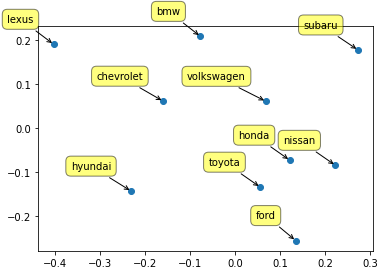

In [ ]:
%matplotlib inline
from sklearn import manifold
import numpy as np
import matplotlib.pyplot as plt

inv_lift = []
lift_matrix_diss = matrix_brands_new
for row in lift_matrix_diss:
  new_row = []
  for val in row:
    if not val: 
      new_row.append(0)
    else:
      new_row.append(1 / val)
  inv_lift.append(new_row)
    
adist = np.array(inv_lift)
amax = np.amax(adist)
adist /= amax

mds = manifold.MDS(n_components=2, dissimilarity='precomputed', random_state=6)
results = mds.fit(adist)

coords = results.embedding_
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    coords[:, 0], coords[:, 1], marker = 'o'
    )

for label, x, y, in zip(top_10_brands, coords[:, 0], coords[:, 1]):
  plt.annotate(
      label,
      xy = (x, y), xytext = (-20, 20),
      textcoords = 'offset points', ha = 'right', va ='bottom',
      bbox = dict(boxstyle = 'round,pad=0.5', fc='yellow', alpha=0.5),
      arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0')
  )

## Analysis

### **Our Most ‘Aspirational’ Brand - Honda**
We defined the most ‘aspirational’ brand as the highest brand/attribute lift value, which may or may not be a positive attribute for the brand. In this case, our most aspirational brand is Honda,’ with a lift value of 3.447342 associated with the word ‘annoying.’ Since our forum is based around car commercials, this most likely means that users are often describing Honda car commercials as annoying. However, it could also mean that users may be describing annoying features of Honda brand cars, but due to the topic that our forum is based around, we cannot draw a firm conclusion without further analysis. Since the lift value is greater than 2, this means that users are twice as likely to mention the words ‘honda’ and ‘annoying’ together in the same comment compared to the baseline value. This implies that the Honda company should conduct further research to determine what exactly customers find annoying about the brand, and devise a strategy based on their findings.    

### **Marketing/Advertising Manager Recommendations**
We recommend to the Honda ad/marketing manager that their commercials appeal to ‘cool,’ ‘funny,’ or ‘love’ aspects of the car/brand, since our frequency analysis shows that these three positive attributes were the top mentioned attributes from forum comments. This could correlate to commercials with cool sound effects or visual graphics, funny storylines, or storylines that induce feelings of love. However, we also recommend that further research be conducted to determine whether ‘annoying’ is actually associated with Honda commercials or associated with Honda cars.    

### **Product Manager Recommendations**
We recommend to the Honda product manager that they define the brand using language that highlights the ‘cool’ or distinguishing features of Honda cars. This will help customers associate the Honda brand with positive connotations, and ideally, their commercials would be associated with those same positive connotations as well. But again, we feel that further information is needed to determine whether this lift value association is referring to the commercials or the cars themselves.     
